# **Vehicle Detection and Tracking** 

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images
* Train a classifier 
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Import packages and display sample image 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from PIL import Image
import pickle 
from skimage.feature import hog

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


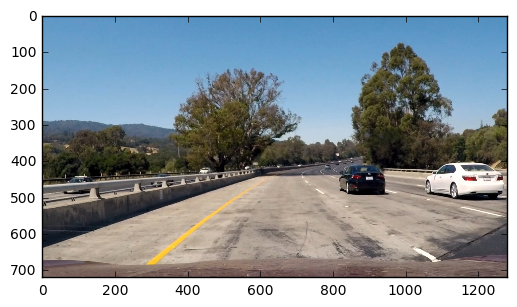

In [2]:
#reading in an image
image = mpimg.imread('./test_images/test1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  

## Functions

Define the functions which is necessary for `Vehicle Detection and Tracking`

In [3]:
# Functions for color features 
def get_color_features(img, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return spatial_features, hist_features

# Function for hog features with color channels  
def get_hog_features(img, cspace='GRAY', orient = 9, pix_per_cell = 8, cell_per_block = 4, hog_channel = 'All'):
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'GRAY':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'RGB':
            feature_image = np.copy(img)
    else: 
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  
        
    if hog_channel == 'All' and cspace != 'GRAY':
        hog_features = np.array([])
        for channel in range(feature_image.shape[2]):
            hog_feature = hog(feature_image[:,:,channel],orientations=orient, \
                                      pixels_per_cell=(pix_per_cell, pix_per_cell), \
                                      cells_per_block=(cell_per_block, cell_per_block), \
                                      visualise=False, feature_vector=False)
            hog_feature = np.ravel(hog_feature)
            hog_features = np.append(hog_features, hog_feature)
            
    elif cspace != 'GRAY':
        hog_feature = hog(feature_image[:,:,hog_channel],orientations=orient, \
                              pixels_per_cell=(pix_per_cell, pix_per_cell), \
                              cells_per_block=(cell_per_block, cell_per_block), \
                              visualise=False, feature_vector=False)
        hog_features = np.ravel(hog_feature)
    else:
        hog_feature = hog(feature_image,orientations=orient, \
                              pixels_per_cell=(pix_per_cell, pix_per_cell), \
                              cells_per_block=(cell_per_block, cell_per_block), \
                              visualise=False, feature_vector=False)
        hog_features = np.ravel(hog_feature)        
    # Return list of feature vectors
    return hog_features
        

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window range is the range of smallest window and biggest window for multiscale window  
# num window type is the type of windows for multi scale window 
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], window_range=(64, 256), num_window_type = 5, xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = img.shape[0]/2
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Define the size of multi scale windows 
    window_size_list = []
    for i in list(range(num_window_type)):
        window_size_list.append( (window_range[0] + int(i * (window_range[1] - window_range[0]) / (num_window_type - 1)))  ) 
        
    # Define the y boundaries of image 
    y_boundary_list = []
    for i in list(range(num_window_type + 1)):
        y_boundary_list.append( (y_start_stop[0] + int(i * (y_start_stop[1] - y_start_stop[0]) / (num_window_type)))  ) 
    
    # Initialize a list to append window positions to
    window_list = []

    for count in list(range(len(window_size_list))):
        current_y = y_boundary_list[count]
        current_window_size = window_size_list[count]
        current_x = 0

        # If window is out of image, then change the y boundary to prior one  
        count_check = 1
        while True:
            if  current_y + current_window_size > img.shape[0]:
                current_y = y_boundary_list[count - count_check]
                count_check += 1
            else:
                break 
        
        Is_first = True
        
        while True:             
            if int(current_y + current_window_size) > y_boundary_list[count + 1] and Is_first == False:
                break
            while True:
                Is_first = False
                start_x = int(current_x)
                end_x = int(start_x + current_window_size)
                start_y = int(current_y)
                end_y = int(current_y + current_window_size)

                if end_x > img.shape[1]:
                    break
                window_list.append(((start_x, start_y), (end_x, end_y)))
                
                current_x += current_window_size * xy_overlap[0]
               
            current_x = 0
            current_y += current_window_size * xy_overlap[1]
                
    # Return the list of windows
    return window_list        
        
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def return_labeled_bboxes(labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # append the boxes to the list 
        boxes.append(bbox)
    # Return the box list 
    return boxes

## Test on Images

Test `Vehicle Detection and Tracking` algorithm to the test images <p>
The process will be as follows
* Perform a `Histogram of Oriented Gradients (HOG)` and `Histogram of Color` feature extraction on a labeled training set of images
* Train a classifier (ex. Linear SVM classifier, Decision tree, 
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

### Histogram of Oriented Gradients and Color Features

Find `histogram of oriented gradients` and `Color features` of training image. 

In [4]:
############################################# Parameters #############################################
# cspace list: 'RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 4
color_hog = 'HLS'

# Define Color parameters
color_space = 'YCrCb'
spatial_size = (32, 32)
bins = 32
range_hist = (0, 256)

Number of Non-vehicle Data: 8968
Number of Vehicle Data: 8792


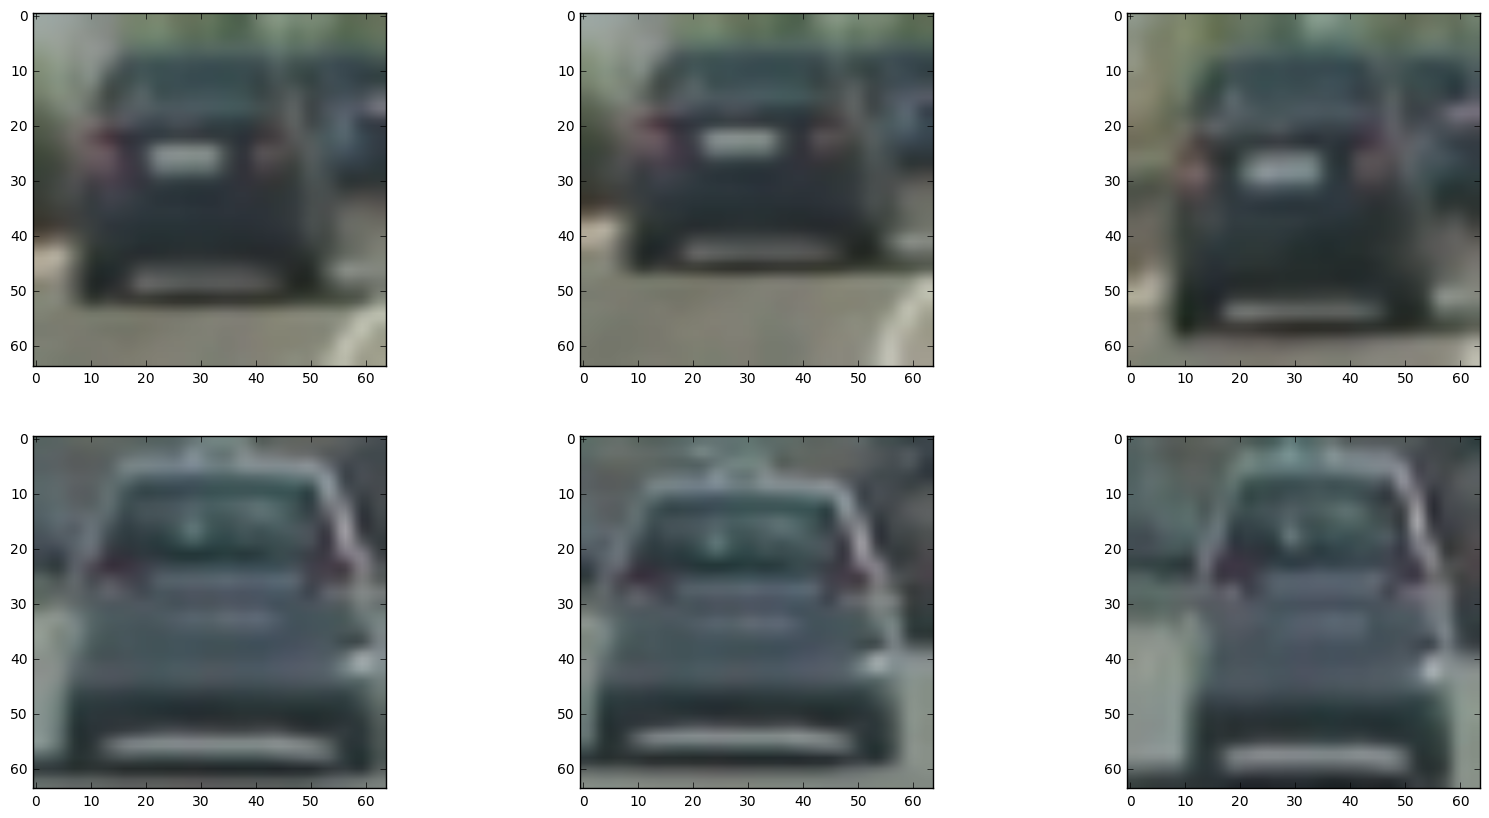

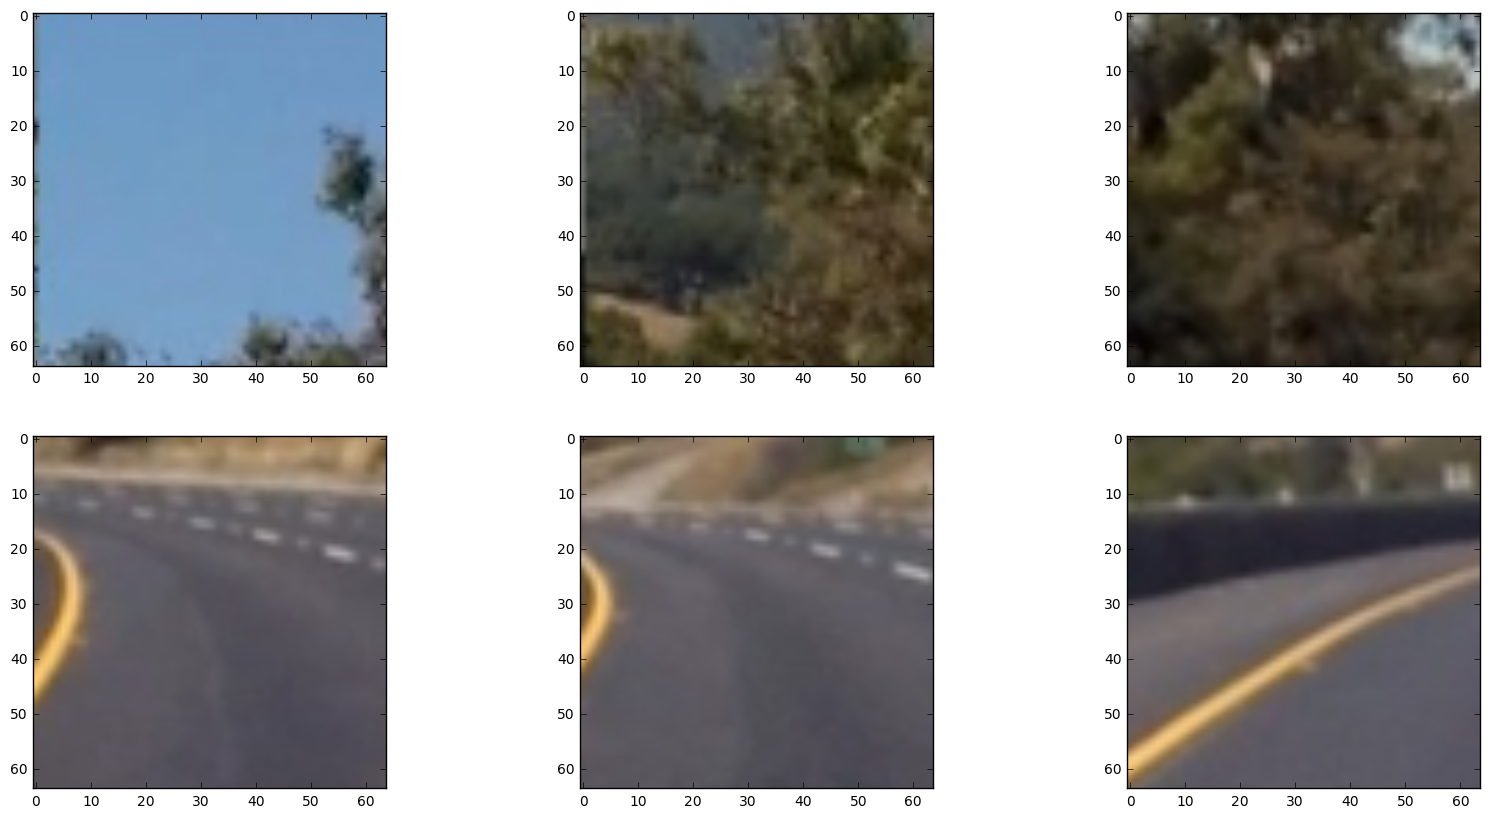

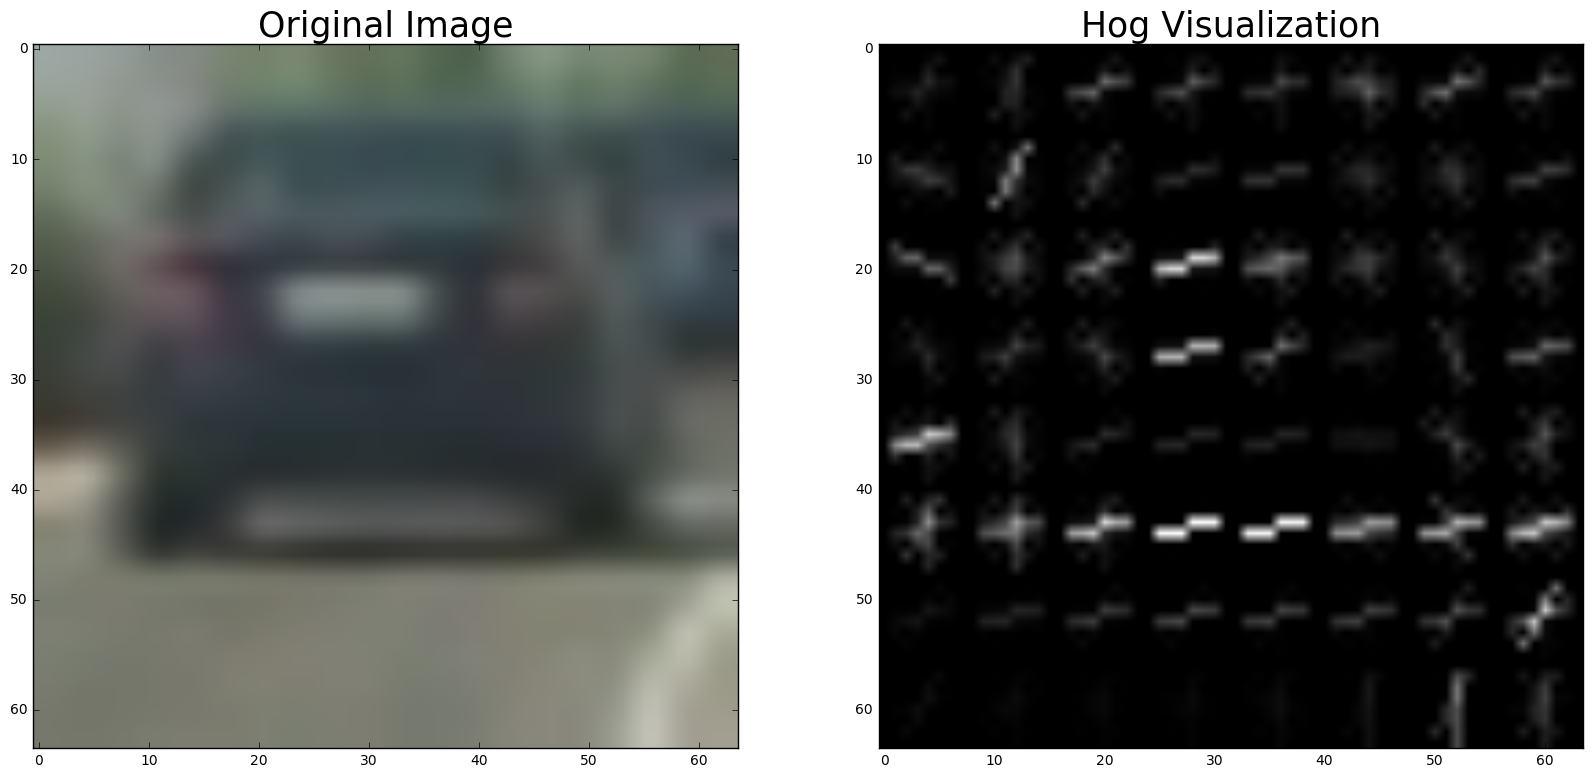

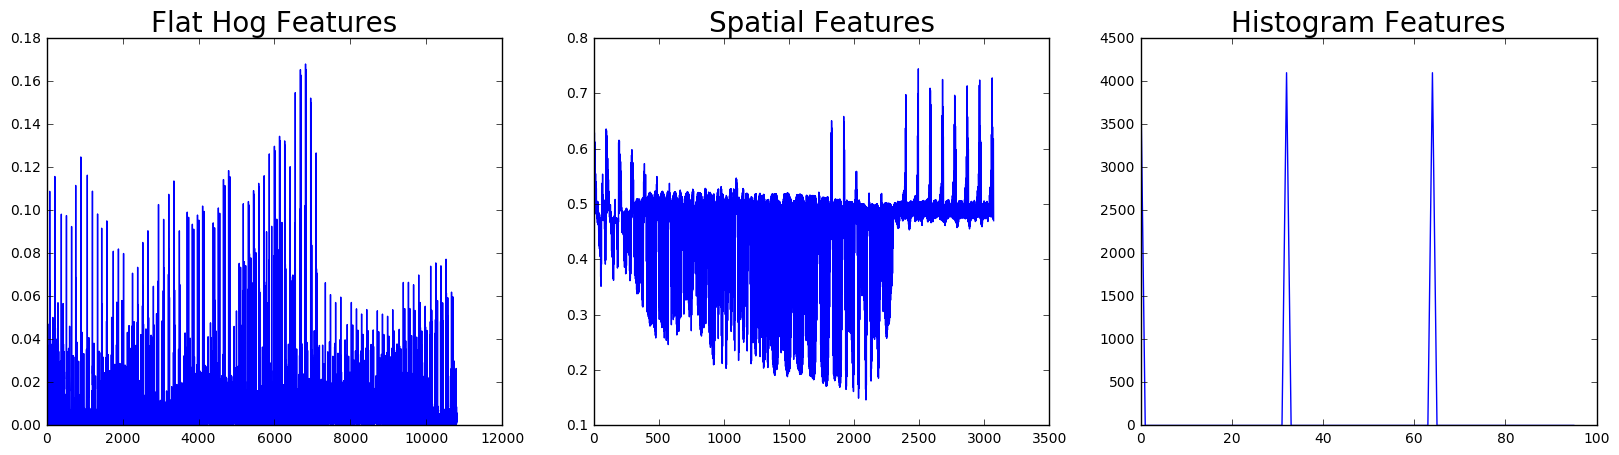

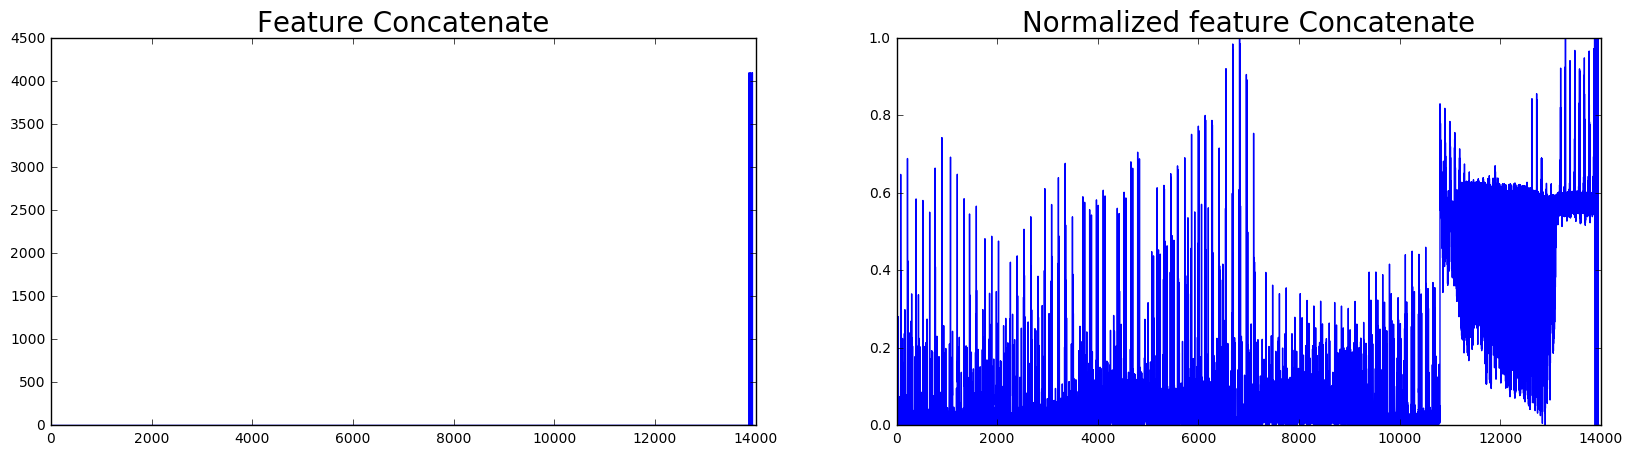

In [5]:
# Get data set path and number of data sets of vehicle and non-vehicle datasets
path = 'D:\Min\Dataset\GTI_vehicle_image_database'

non_vehicle_folder_list = os.listdir(path + '\\non-vehicles')
vehicle_folder_list = os.listdir(path + '\\vehicles')

non_vehicle_path_list = []
vehicle_path_list = []

for non_vehicle_folder in non_vehicle_folder_list:
    for non_vehicle_file in os.listdir(path + '\\non-vehicles' + '\\' + non_vehicle_folder):
        non_vehicle_path_list.append(path + '\\non-vehicles' + '\\' + non_vehicle_folder + '\\' + non_vehicle_file) 
    
for vehicle_folder in vehicle_folder_list:
    for vehicle_file in os.listdir(path + '\\vehicles' + '\\' + vehicle_folder):
        vehicle_path_list.append(path + '\\vehicles' + '\\' + vehicle_folder + '\\' + vehicle_file)
    
print('Number of Non-vehicle Data: ' + str(len(non_vehicle_path_list)))
print('Number of Vehicle Data: ' + str(len(vehicle_path_list)))

# CarImage Visualization
fig = plt.figure(0, figsize=(20,10))
ax1 = fig.add_subplot(231)
ax1.imshow(mpimg.imread(vehicle_path_list[0]))
ax2 = fig.add_subplot(232)
ax2.imshow(mpimg.imread(vehicle_path_list[1]))
ax3 = fig.add_subplot(233)
ax3.imshow(mpimg.imread(vehicle_path_list[2]))
ax4 = fig.add_subplot(234)
ax4.imshow(mpimg.imread(vehicle_path_list[3]))
ax5 = fig.add_subplot(235)
ax5.imshow(mpimg.imread(vehicle_path_list[4]))
ax6 = fig.add_subplot(236)
ax6.imshow(mpimg.imread(vehicle_path_list[5]))
          
# Non-CarImage Visualization
fig = plt.figure(1, figsize=(20,10))
ax1 = fig.add_subplot(231)
ax1.imshow(mpimg.imread(non_vehicle_path_list[0]))
ax2 = fig.add_subplot(232)
ax2.imshow(mpimg.imread(non_vehicle_path_list[1]))
ax3 = fig.add_subplot(233)
ax3.imshow(mpimg.imread(non_vehicle_path_list[2]))
ax4 = fig.add_subplot(234)
ax4.imshow(mpimg.imread(non_vehicle_path_list[3]))
ax5 = fig.add_subplot(235)
ax5.imshow(mpimg.imread(non_vehicle_path_list[4]))
ax6 = fig.add_subplot(236)
ax6.imshow(mpimg.imread(non_vehicle_path_list[5]))

# To make example image of each features
image = mpimg.imread(vehicle_path_list[1])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

##################################################### Hog #####################################################
# Use skimage.hog() to get hog features and hog image 

hog_features, hog_image = hog(gray,orientations=orient, \
                          pixels_per_cell=(pix_per_cell, pix_per_cell), \
                          cells_per_block=(cell_per_block, cell_per_block), \
                          visualise=True, feature_vector=False)

flat_hog_features = get_hog_features(image, cspace=color_hog, orient = orient, 
                                     pix_per_cell = pix_per_cell, 
                                     cell_per_block = cell_per_block, hog_channel = 'All')

# Hog Visualization
title_font_size = 25
fig = plt.figure(2, figsize=(20,10))

ax1 = fig.add_subplot(121)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize = title_font_size)

ax2 = fig.add_subplot(122)
ax2.imshow(hog_image, cmap = 'gray')
ax2.set_title('Hog Visualization', fontsize = title_font_size)

##################################################### Color #####################################################
from sklearn.preprocessing import StandardScaler

# Get color features 
spatial_features, hist_features = get_color_features(image, cspace = color_space, spatial_size = spatial_size, hist_bins = bins, hist_range = range_hist)

# Color Visualization 
title_font_size = 20
fig = plt.figure(3, figsize = (20,5))

ax1 = fig.add_subplot(131)
ax1.plot(flat_hog_features)
ax1.set_title('Flat Hog Features', fontsize = title_font_size)

ax2 = fig.add_subplot(132)
ax2.plot(spatial_features)
ax2.set_title('Spatial Features', fontsize = title_font_size)

ax3 = fig.add_subplot(133)
ax3.plot(hist_features)
ax3.set_title('Histogram Features', fontsize = title_font_size)

fig = plt.figure(4, figsize = (20,5))

ax1 = fig.add_subplot(121)
feature_concat = np.concatenate((flat_hog_features, spatial_features, hist_features))
ax1.plot(feature_concat)
ax1.set_title('Feature Concatenate', fontsize = title_font_size)

ax2 = fig.add_subplot(122)
# Normalization
norm_hog = (flat_hog_features - np.min(flat_hog_features)) / (np.max(flat_hog_features) - np.min(flat_hog_features))
norm_spatial = (spatial_features - np.min(spatial_features)) / (np.max(spatial_features) - np.min(spatial_features))
norm_hist = (hist_features - np.min(hist_features)) / (np.max(hist_features) - np.min(hist_features))
normconcat = np.concatenate((norm_hog, norm_spatial, norm_hist))

ax2.plot(normconcat)
ax2.set_title('Normalized feature Concatenate', fontsize = title_font_size)



### Make Training and Test dataset 

Make training and test dataset with labeled images as pickle file 

**If you already have a dataset then pass this section!!!**

In [6]:
num_features = len(feature_concat)
num_label = 2

##################################################  Making non vehicle data matrix #############################################

Data_X_non = np.zeros((1, num_features))
Data_Y_non = np.zeros((1, 1))

y_label_non = np.zeros((1, 1))
y_label_non[0] = 0

array_num = 1
counter = 0

X_data_list_non = []
Y_data_list_non = []

print('------------------------------------ Non Vehicle Data ------------------------------------')
for non_vehicle in non_vehicle_path_list:
    # Open image and make it as grayscale image 
    image = mpimg.imread(non_vehicle)

    # HOG features
    flat_hog_features = get_hog_features(image, cspace=color_hog, orient = orient, 
                                         pix_per_cell = pix_per_cell, 
                                         cell_per_block = cell_per_block, hog_channel = 'All')
    # Color features
    spatial_features, hist_features = get_color_features(image, cspace=color_space, spatial_size = spatial_size, hist_bins = bins, hist_range = range_hist)
    
    # Normalization
    norm_hog = (flat_hog_features - np.min(flat_hog_features)) / (np.max(flat_hog_features) - np.min(flat_hog_features))
    norm_spatial = (spatial_features - np.min(spatial_features)) / (np.max(spatial_features) - np.min(spatial_features))
    norm_hist = (hist_features - np.min(hist_features)) / (np.max(hist_features) - np.min(hist_features))
    normconcat = np.concatenate((norm_hog, norm_spatial, norm_hist))
                
    Data_X_non = np.insert(Data_X_non, array_num, normconcat, 0)
    Data_Y_non = np.insert(Data_Y_non, array_num, y_label_non, 0)
                
    array_num += 1
    counter += 1

    if counter % 500 == 0:
        Data_X_non = np.delete(Data_X_non, (0), axis=0)
        Data_Y_non = np.delete(Data_Y_non, (0), axis=0)
        X_data_list_non.append(Data_X_non)
        Y_data_list_non.append(Data_Y_non)
        Data_X_non = np.zeros((1, num_features))
        Data_Y_non = np.zeros((1, 1))
        array_num = 1    
    
        print(str(counter) + '/' + str(len(non_vehicle_path_list)))

Data_X_non = np.delete(Data_X_non, (0), axis=0)
Data_Y_non = np.delete(Data_Y_non, (0), axis=0)

X_data_list_non.append(Data_X_non)
Y_data_list_non.append(Data_Y_non)

Data_X_non = np.zeros((1, num_features))
Data_Y_non = np.zeros((1, 1))

for i in list(range(len(Y_data_list_non))):
    Data_X_non = np.insert(Data_X_non, 1, X_data_list_non[i], 0)
    Data_Y_non = np.insert(Data_Y_non, 1, Y_data_list_non[i], 0)
    print(str(i + 1) + ' / ' + str(len(X_data_list_non)))

Data_X_non = np.delete(Data_X_non, (0), axis=0)
Data_Y_non = np.delete(Data_Y_non, (0), axis=0)    
    
##################################################  Making non vehicle data matrix #############################################

Data_X_vehicle = np.zeros((1, num_features))
Data_Y_vehicle = np.zeros((1, 1))

y_label_vehicle = np.zeros((1, 1))
y_label_vehicle[0] = 1

array_num = 1
counter = 0

X_data_list_vehicle = []
Y_data_list_vehicle = []

print('------------------------------------ Vehicle Data ------------------------------------')

for vehicle in vehicle_path_list:
    # Open image and make it as grayscale image 
    image = mpimg.imread(vehicle)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # HOG Features
    flat_hog_features = get_hog_features(image, cspace=color_hog, orient = orient, 
                                         pix_per_cell = pix_per_cell, 
                                         cell_per_block = cell_per_block, hog_channel = 'All')
    # Color features
    spatial_features, hist_features = get_color_features(image, cspace=color_space, spatial_size = spatial_size, hist_bins = bins, hist_range = range_hist)

    # Normalization
    norm_hog = (flat_hog_features - np.min(flat_hog_features)) / (np.max(flat_hog_features) - np.min(flat_hog_features))
    norm_spatial = (spatial_features - np.min(spatial_features)) / (np.max(spatial_features) - np.min(spatial_features))
    norm_hist = (hist_features - np.min(hist_features)) / (np.max(hist_features) - np.min(hist_features))
    normconcat = np.concatenate((norm_hog, norm_spatial, norm_hist))
    
    Data_X_vehicle = np.insert(Data_X_vehicle, array_num, normconcat, 0)
    Data_Y_vehicle = np.insert(Data_Y_vehicle, array_num, y_label_vehicle, 0)
                
    array_num += 1
    counter += 1
    
    if counter % 500 == 0:
        Data_X_vehicle = np.delete(Data_X_vehicle, (0), axis=0)
        Data_Y_vehicle = np.delete(Data_Y_vehicle, (0), axis=0)
        X_data_list_vehicle.append(Data_X_vehicle)
        Y_data_list_vehicle.append(Data_Y_vehicle)
        Data_X_vehicle = np.zeros((1, num_features))
        Data_Y_vehicle = np.zeros((1, 1))
        array_num = 1    
    
        print(str(counter) + '/' + str(len(vehicle_path_list)))

Data_X_vehicle = np.delete(Data_X_vehicle, (0), axis=0)
Data_Y_vehicle = np.delete(Data_Y_vehicle, (0), axis=0)

X_data_list_vehicle.append(Data_X_vehicle)
Y_data_list_vehicle.append(Data_Y_vehicle)

Data_X_vehicle = np.zeros((1, num_features))
Data_Y_vehicle = np.zeros((1, 1))


for i in list(range(len(Y_data_list_vehicle))):
    Data_X_vehicle = np.insert(Data_X_vehicle, 1, X_data_list_vehicle[i], 0)
    Data_Y_vehicle = np.insert(Data_Y_vehicle, 1, Y_data_list_vehicle[i], 0)
    print(str(i + 1) + ' / ' + str(len(X_data_list_non)))

Data_X_vehicle = np.delete(Data_X_vehicle, (0), axis=0)
Data_Y_vehicle = np.delete(Data_Y_vehicle, (0), axis=0)    

############################################  Merge the non-vehicle and vehicle matrix #######################################
print('Merging the vehicle and non-vehicle data')
Data_X = np.zeros((1, num_features))
Data_Y = np.zeros((1, 1))

Data_X = np.insert(Data_X, 1, Data_X_non, 0)
Data_Y = np.insert(Data_Y, 1, Data_Y_non, 0)
Data_X = np.insert(Data_X, 1, Data_X_vehicle, 0)
Data_Y = np.insert(Data_Y, 1, Data_Y_vehicle, 0)

Data_X = np.delete(Data_X, (0), axis=0)
Data_Y = np.delete(Data_Y, (0), axis=0)  

#################################################  Shuffle and divide the data  ############################################
print('Shuffle and dividing the data')
from sklearn.utils import shuffle
n_data = Data_Y.shape[0]
n_test = int(n_data * 0.1)
n_train = n_data - n_test

Data_X, Data_Y = shuffle(Data_X, Data_Y)

X_train = Data_X[: n_train, :]
X_test = Data_X[n_train :, :]
Y_train = Data_Y[:n_train, :]
Y_test = Data_Y[n_train:, :]

data = {'X_train': X_train, 'Y_train': Y_train.ravel(), 'X_test': X_test, 'Y_test': Y_test.ravel()}

#################################################  Save the data as pickle format ############################################
print('Saving data as pickle')

save_path = 'D:\Min\Dataset\GTI_vehicle_image_database\dataset.pkl'
f = open(save_path, 'wb')
pickle.dump(data, f)
f.close 

print('\nData is saved at "' + save_path + '"')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test: ' + str(X_test.shape))
print('Y_test: ' + str(Y_test.shape))

------------------------------------ Non Vehicle Data ------------------------------------
500/8968
1000/8968
1500/8968
2000/8968
2500/8968
3000/8968
3500/8968
4000/8968
4500/8968
5000/8968
5500/8968
6000/8968
6500/8968
7000/8968
7500/8968
8000/8968
8500/8968
1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18
18 / 18
------------------------------------ Vehicle Data ------------------------------------
500/8792
1000/8792
1500/8792
2000/8792
2500/8792
3000/8792
3500/8792
4000/8792
4500/8792
5000/8792
5500/8792
6000/8792
6500/8792
7000/8792
7500/8792
8000/8792
8500/8792
1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18
18 / 18
Merging the vehicle and non-vehicle data
Shuffle and dividing the data
Saving data as pickle

Data is saved at "D:\Min\Dataset\GTI_vehicle_image_database\dataset.pkl"
X_train: (15984, 13968)
Y_train: (15984, 1)
X_t

#### Training the classifier with saved dataset

Train the classifier with the dataset pickle file. 
I will use `SVM` as a classifier for this project

In [7]:
# Load the saved data 
print('------------------- Loding the data -------------------')

save_path = 'D:\Min\Dataset\GTI_vehicle_image_database\dataset.pkl'

pkl_file = open(save_path, 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

X_train = data['X_train']
Y_train = data['Y_train']
X_test = data['X_test']
Y_test = data['Y_test']

print('------------------- Data is loaded -------------------')

------------------- Loding the data -------------------
------------------- Data is loaded -------------------


In [8]:
############################################ SVM ############################################
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import time

print('Start learning')
start_learning_time = time.time()

svc = LinearSVC()
svc.fit(X_train, Y_train.ravel())

learning_time = time.time() - start_learning_time 
print('Time to train SVC (sec): ' + str(learning_time))

# Prediction of test data
pred = svc.predict(X_test)

# Accuracy of prediction and y label
acc = accuracy_score(pred, Y_test.ravel())

print('Test data accuracy(SVM): ' + str(acc))


Start learning
Time to train SVC (sec): 72.82316517829895
Test data accuracy(SVM): 0.986486486486


In [9]:
############################################ ANN ############################################
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

y_one_hot = np.zeros((len(Y_train), 2))
for i in list(range(len(Y_train))):
    y_one_hot[i, int(Y_train[i])] = 1

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_train, y_one_hot, nb_epoch = 30, batch_size = 500, validation_split = 0.1)

y_one_hot_test = np.zeros((len(Y_test), 2))
for i in list(range(len(Y_test))):
    y_one_hot_test[i, int(Y_test[i])] = 1
    
metrics = model.evaluate(X_test, y_one_hot_test)
print('\nLoss: ' + str(metrics[0]))
print('Accuracy: ' + str(metrics[1]))

Using TensorFlow backend.


Train on 14385 samples, validate on 1599 samples
Epoch 1/30
14385/14385 [==============================] - 5s - loss: 0.7654 - acc: 0.6165 - val_loss: 0.3806 - val_acc: 0.8931
Epoch 2/30
14385/14385 [==============================] - 2s - loss: 0.2776 - acc: 0.8971 - val_loss: 0.1072 - val_acc: 0.9650
Epoch 3/30
14385/14385 [==============================] - 2s - loss: 0.1638 - acc: 0.9445 - val_loss: 0.0769 - val_acc: 0.9731
Epoch 4/30
14385/14385 [==============================] - 2s - loss: 0.1219 - acc: 0.9608 - val_loss: 0.0605 - val_acc: 0.9800
Epoch 5/30
14385/14385 [==============================] - 2s - loss: 0.1142 - acc: 0.9605 - val_loss: 0.0621 - val_acc: 0.9800
Epoch 6/30
14385/14385 [==============================] - 2s - loss: 0.1257 - acc: 0.9515 - val_loss: 0.0549 - val_acc: 0.9806
Epoch 7/30
14385/14385 [==============================] - 2s - loss: 0.0915 - acc: 0.9625 - val_loss: 0.0553 - val_acc: 0.9825
Epoch 8/30
14385/14385 [==============================] - 2s -

### Sliding Window 

Sliding window technique to find vehicles 


Number of total windows: 292
There are 4 numbers of vehicle windows

Number of total windows: 292
There are 0 numbers of vehicle windows

Number of total windows: 292
There are 0 numbers of vehicle windows

Number of total windows: 292
There are 4 numbers of vehicle windows

Number of total windows: 292
There are 3 numbers of vehicle windows

Number of total windows: 292
There are 3 numbers of vehicle windows


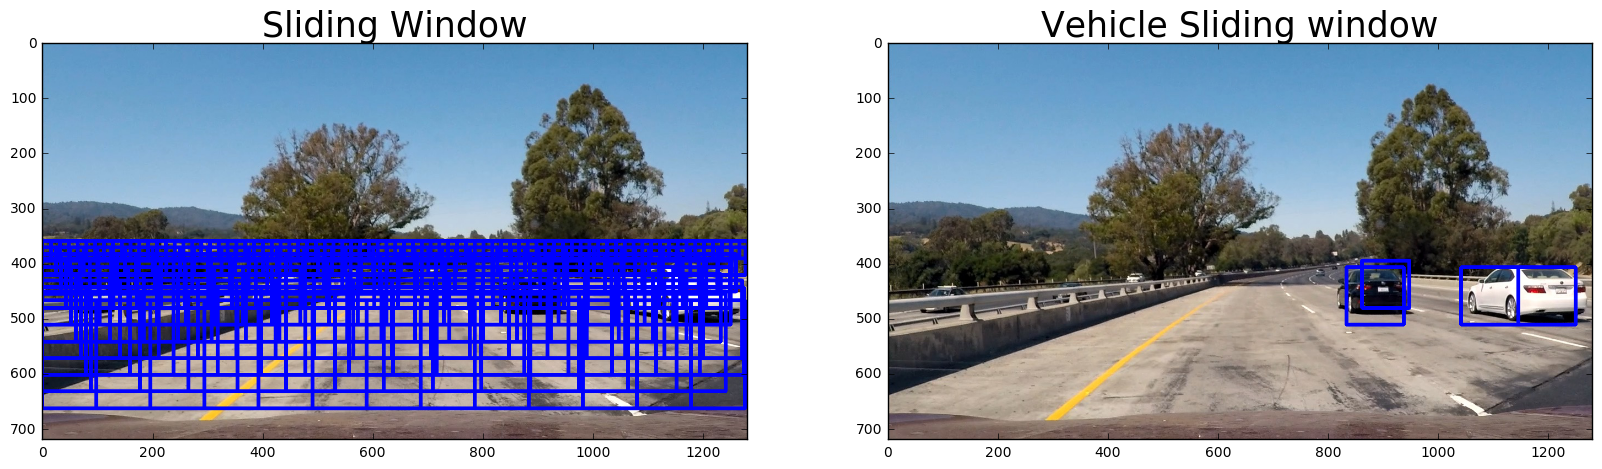

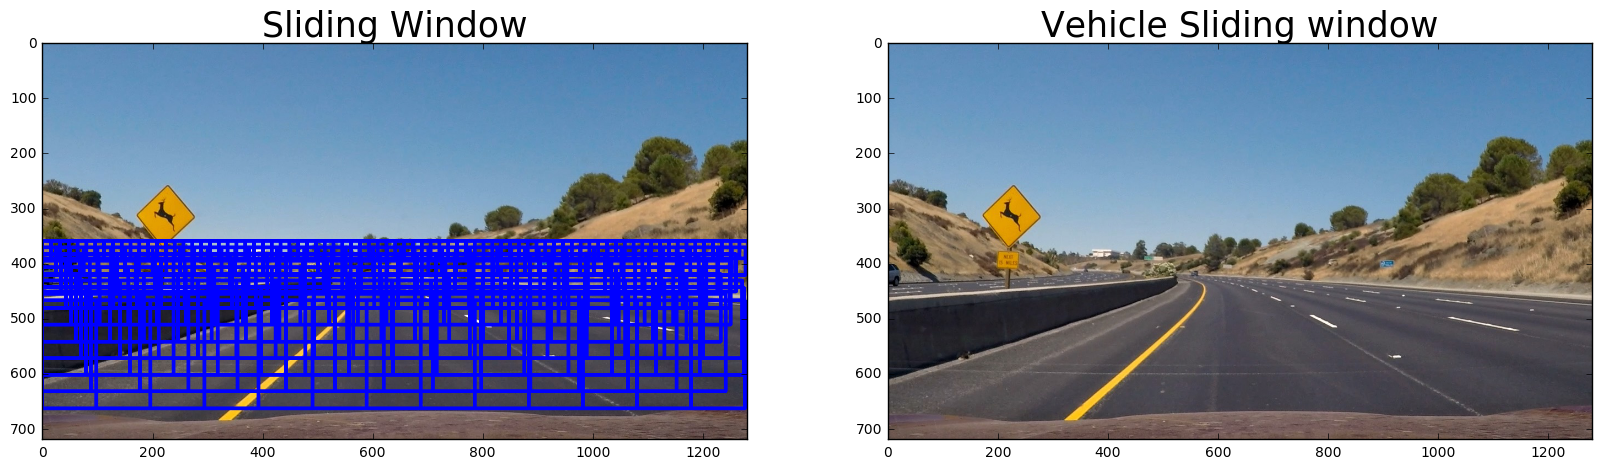

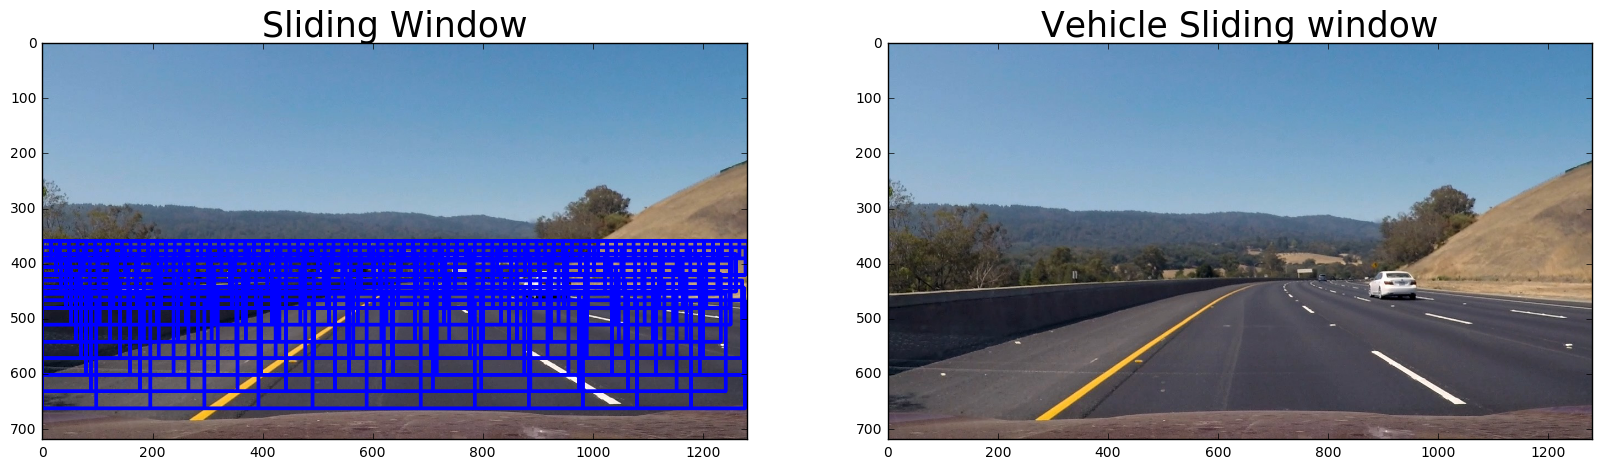

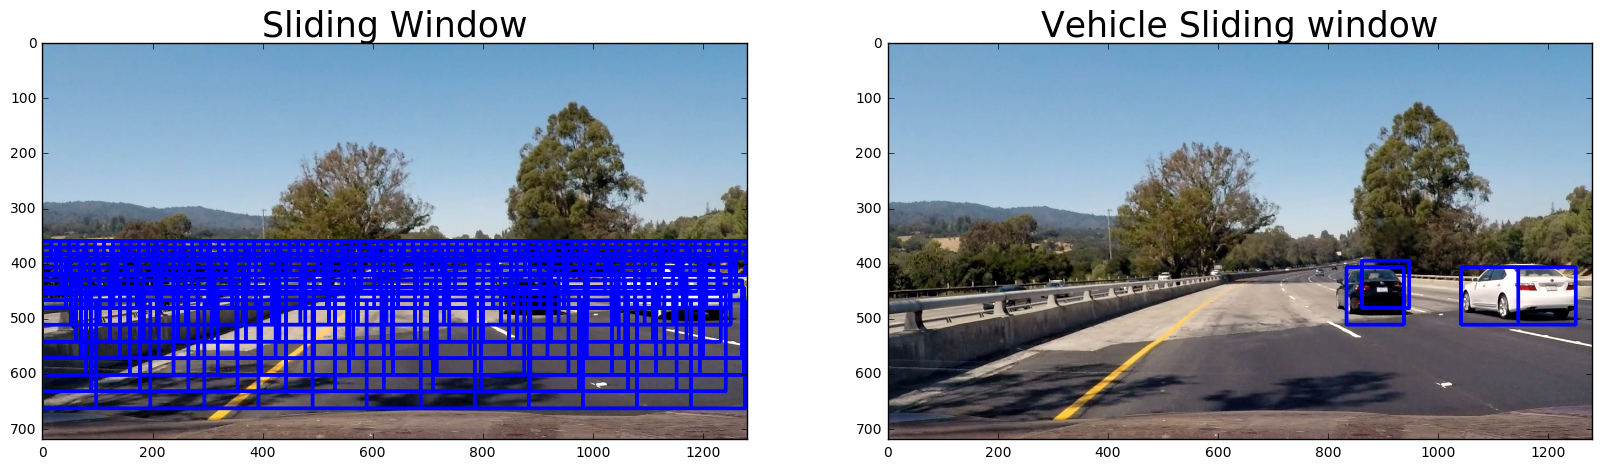

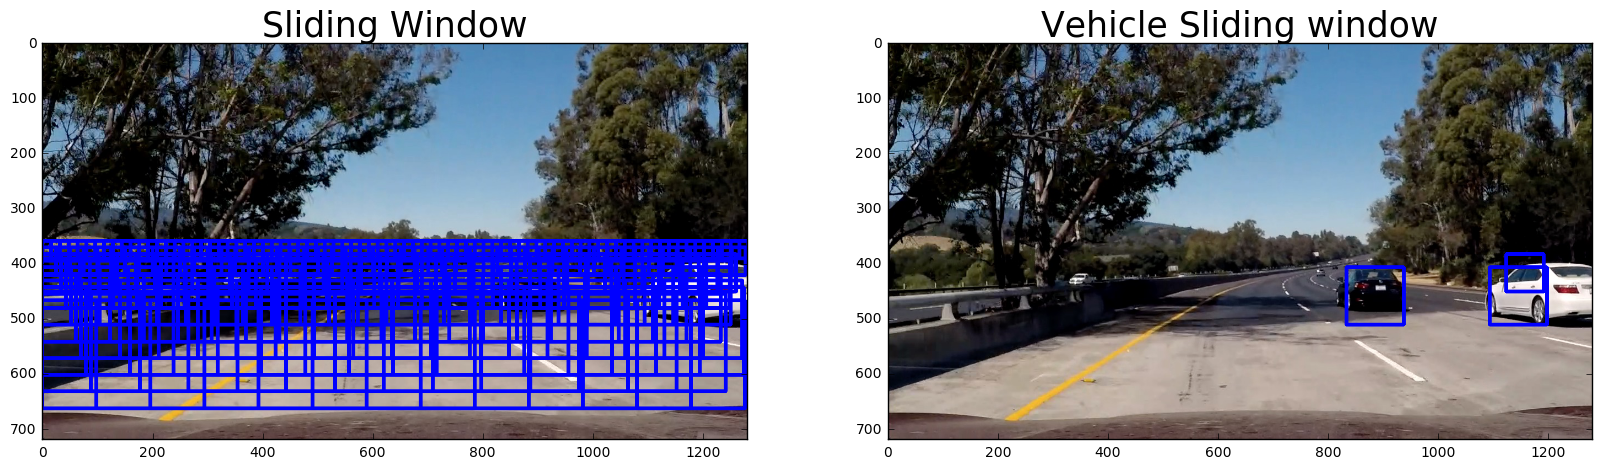

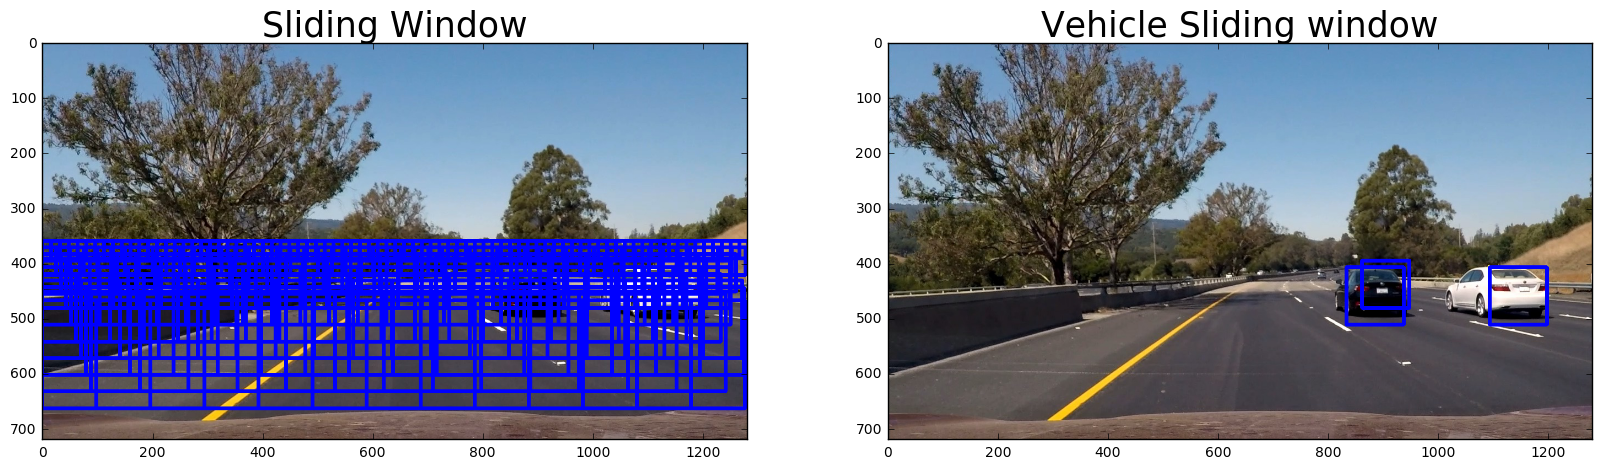

In [10]:
test_image_path = './test_images/'
test_image_list = os.listdir(test_image_path)

for num, test_image in enumerate(test_image_list):
    img = mpimg.imread(test_image_path + test_image)
    img_size = [img.shape[1], img.shape[0]]

    ############################################# Sliding windows #############################################

    window_list = slide_window(img, x_start_stop=[None, None], y_start_stop=[int(img_size[1]/2), int(img_size[1] - img_size[1]/3)], 
                               window_range=(32, 196), num_window_type = 10, xy_overlap=(0.5, 0.5))
    num_window = len(window_list)

    img_copy = np.copy(img)
    img_boxes = draw_boxes(img_copy, window_list, color=(0, 0, 255), thick=6) 

    print('\nNumber of total windows: ' + str(num_window))

    ############################################# Finding target windows #############################################
    vehicle_window = []
    for window in window_list:

        img_window = cv2.resize(img[window[0][1] : window[1][1], window[0][0] : window[1][0]], (64, 64))

        # Apply hog
        flat_hog_features = get_hog_features(img_window, cspace=color_hog, orient = orient, 
                                             pix_per_cell = pix_per_cell, 
                                             cell_per_block = cell_per_block, hog_channel = 'All')
        # Color features
        spatial_features, hist_features = get_color_features(img_window, cspace=color_space, spatial_size = spatial_size, hist_bins = bins, hist_range = range_hist)

        # Normalization
        norm_hog = (flat_hog_features - np.min(flat_hog_features)) / (np.max(flat_hog_features) - np.min(flat_hog_features))
        norm_spatial = (spatial_features - np.min(spatial_features)) / (np.max(spatial_features) - np.min(spatial_features))
        norm_hist = (hist_features - np.min(hist_features)) / (np.max(hist_features) - np.min(hist_features))
        normconcat = np.concatenate((norm_hog, norm_spatial, norm_hist))

        # Prediction of Features in window
        pred_NN = model.predict(normconcat.reshape(1, -1), batch_size=1)
        
     
        if pred_NN[0,1] > 0.80:
            vehicle_window.append(window)
    
            
    print('There are %d numbers of vehicle windows'%(len(vehicle_window)))

    img_copy = np.copy(img)
    img_boxes_vehicle = draw_boxes(img_copy, vehicle_window, color=(0, 0, 255), thick=6) 

    title_font_size = 25
    fig = plt.figure(num, figsize=(20,10))

    ax1 = fig.add_subplot(121)
    ax1.imshow(img_boxes)
    ax1.set_title('Sliding Window', fontsize = title_font_size)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img_boxes_vehicle, cmap = 'gray')
    ax2.set_title('Vehicle Sliding window', fontsize = title_font_size)

## Test on Videos

* Use `test video` to check the windows in several frames. 
* Use `project video` to verify the vehicle finding and tracking algorithm 

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
from scipy.ndimage.measurements import label

def process_image(img):
    # define the values which is used in the process image function 
    img_heat_map = np.zeros_like(img[:,:,0]).astype(np.float)       
    img_heat_map_thresh = np.zeros_like(img[:,:,0]).astype(np.float)  
    
    if not hasattr(process_image, "heat_map_list"):
        process_image.heat_map_list = []   

    if not hasattr(process_image, "len_interest_boxes"):
        process_image.len_interest_boxes = []   

    if not hasattr(process_image, "interest_boxes"):
        process_image.interest_boxes = []   
        
    heat_map_sum = np.zeros_like(img[:,:,0]).astype(np.float)
    
    img_size = [img.shape[1], img.shape[0]]

    ############################################# Sliding windows #############################################

    window_list = slide_window(img, x_start_stop=[None, None], y_start_stop=[int(img_size[1]/2), int(img_size[1] - img_size[1]/3)], 
                               window_range=(48, 196), num_window_type = 10, xy_overlap=(0.5, 0.5))

    ############################################# Finding target windows #############################################
    vehicle_window = []
    for window in window_list:
     
        img_window = cv2.resize(img[window[0][1] : window[1][1], window[0][0] : window[1][0]], (64, 64))
        img_window_gray = cv2.cvtColor(img_window, cv2.COLOR_RGB2GRAY)

        # Apply hog
        flat_hog_features = get_hog_features(img_window, cspace=color_hog, orient = orient, 
                                             pix_per_cell = pix_per_cell, 
                                             cell_per_block = cell_per_block, hog_channel = 'All')
    
        spatial_features, hist_features = get_color_features(img_window, cspace=color_space, spatial_size = spatial_size, hist_bins = bins, hist_range = range_hist)


        # Normalization
        norm_hog = (flat_hog_features - np.min(flat_hog_features)) / np.max(flat_hog_features)
        norm_spatial = (spatial_features - np.min(spatial_features)) / np.max(spatial_features)
        norm_hist = (hist_features - np.min(spatial_features)) / np.max(hist_features)
        normconcat = np.concatenate((norm_hog, norm_spatial, norm_hist))

        # Prediction of Features in window
        pred_NN = model.predict(normconcat.reshape(1, -1), batch_size=1)
        
        # If window is classified as vehicle then save the window
        if pred_NN[0,1] > 0.85:
            vehicle_window.append(window)
        
    ############################################# Remove False-Positive #############################################
    # Use heatmap
    heatmap = add_heat(img_heat_map, vehicle_window)
    
    if len(process_image.heat_map_list) >= 15:
        del process_image.heat_map_list[0]
        
    process_image.heat_map_list.append(heatmap)
    
    for m in process_image.heat_map_list:
        heat_map_sum += m
  
    window_heatmap = []
    for box in vehicle_window:
        if np.max(heat_map_sum[box[0][1]:box[1][1], box[0][0]:box[1][0]]) > 10:
            window_heatmap.append(box)
    
    # Use box of interest 
    # If window has more heat value than threshold, add it to box of interest list 
    if len(window_heatmap) > 0:
        process_image.interest_boxes.extend(window_heatmap)
        process_image.len_interest_boxes.append(len(window_heatmap))
    
    # If the number of boxes of interest is more than threshold, then add it to final window list 
    window_thresh = []
    if len(process_image.interest_boxes) > 0:
        for interest_box in process_image.interest_boxes:
            if process_image.interest_boxes.count(interest_box) >= 2 and interest_box not in window_thresh:
                window_thresh.append(interest_box)
                
    if len(process_image.interest_boxes) > 0:
        if len(process_image.len_interest_boxes) > 6:
            for len_del_box in list(range(process_image.len_interest_boxes[0])):
                del process_image.interest_boxes[0]
            del process_image.len_interest_boxes [0]
    
    # Use label function to combine the overlapping bound boxes
    heatmap_thresh = add_heat(img_heat_map_thresh, window_thresh)
    labels = label(heatmap_thresh)
    returned_boxes = return_labeled_bboxes(labels)

    # Save heatmap 
#     import time
#     current_time = time.time()
#     mpimg.imsave('./images/' + str(current_time) + ".png", 255 * (heatmap / np.max(heatmap)), cmap = 'hot')


    img_copy = np.copy(img)
    img_boxes_vehicle = draw_labeled_bboxes(img_copy, labels)
    
    return img_boxes_vehicle


### Test Video

In [18]:
from moviepy.editor import *

test_output = 'test.mp4'
clip1 = VideoFileClip("./test_video.mp4")
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:40<00:01,  1.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

Wall time: 40.9 s


Check out the result of test video! 

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

### Project Video

In [12]:
project_output = 'project.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████████████████████████████████▉| 1260/1261 [20:00<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

Wall time: 20min


Check out the result of project video! 

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))